### 1. Import Library & Define Functions
* 라이브러리를 로드
* 학습 및 추론에 필요한 함수와 클래스를 정의

In [1]:
import os
import time
import random
import cv2
import wandb

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
import albumentations as A
import augraphy
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt

In [2]:
# 시드 고정 
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
wandb.login(key="")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aylee (lay_aylee). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /data/ephemeral/home/.netrc


True

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="CV",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset

    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()


wandb: Currently logged in as: aylee (lay_aylee). Use `wandb login --relogin` to force relogin


acc,▁▅▆█▇███
loss,██▃▄▂▁▂▂
acc,0.75774
loss,0.27798


### 2. EDA

In [3]:
df = pd.read_csv('/data/ephemeral/home/data/meta.csv')

labels_map = df.set_index('target')['class_name'].to_dict()
labels_map

{0: 'account_number',
 1: 'application_for_payment_of_pregnancy_medical_expenses',
 2: 'car_dashboard',
 3: 'confirmation_of_admission_and_discharge',
 4: 'diagnosis',
 5: 'driver_lisence',
 6: 'medical_bill_receipts',
 7: 'medical_outpatient_certificate',
 8: 'national_id_card',
 9: 'passport',
 10: 'payment_confirmation',
 11: 'pharmaceutical_receipt',
 12: 'prescription',
 13: 'resume',
 14: 'statement_of_opinion',
 15: 'vehicle_registration_certificate',
 16: 'vehicle_registration_plate'}

In [ ]:
# 이미지 파일 리스트
train_dir = '/data/ephemeral/home/data/train/' # 이미지가 저장된 폴더 이름
test_dir = '/data/ephemeral/home/data/test/'
img_file_list = [f for f in os.listdir(train_dir) if f.endswith('.jpg')] # 해당 폴더 아래에 .jpg 확장자로 된 파일들 취합
# img_file_list = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]
img_file_list.sort()

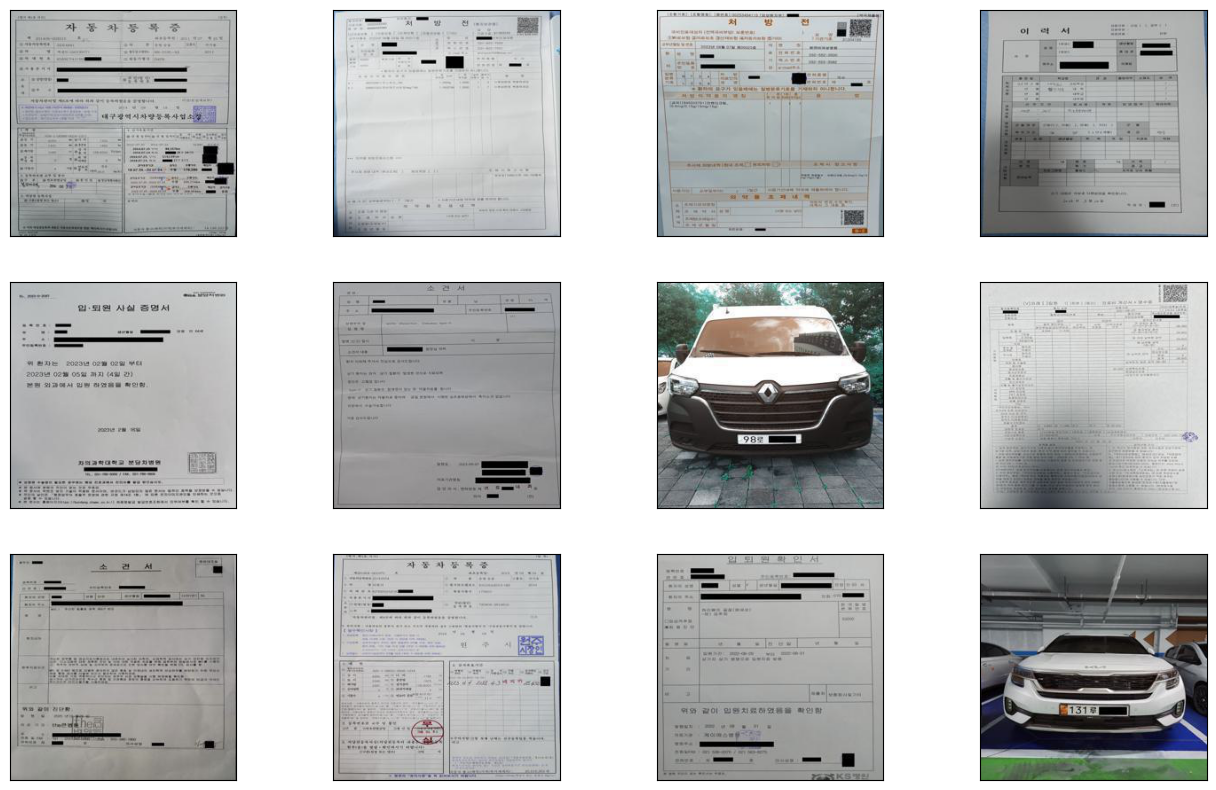

In [ ]:
# 이미지 파일 리스트 샘플링
sample_size = 12  # 시각화할 이미지 수
sampled_files = random.sample(img_file_list, sample_size)

# 이미지 시각화
plt.figure(figsize=(16, 10))

for i, f in enumerate(sampled_files):
    plt.subplot(3, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = Image.open(train_dir + f)
    
    # 이미지 크기 조정 (옵션)
    img.thumbnail((256, 256)) 
    
    plt.imshow(img)
plt.show()

In [ ]:
# 데이터 경로 설정
train_data_dir = '/data/ephemeral/home/data/train'
test_data_dir = '/data/ephemeral/home/data/test'
train_labels_file = '/data/ephemeral/home/data/train.csv'

In [ ]:
# 1. 데이터의 기본 정보 확인

# 훈련 이미지 파일 리스트 얻기
train_image_files = [f for f in os.listdir(train_data_dir) if os.path.isfile(os.path.join(train_data_dir, f))]

# 테스트 이미지 파일 리스트 얻기
test_image_files = [f for f in os.listdir(test_data_dir) if os.path.isfile(os.path.join(test_data_dir, f))]

# 전체 이미지 수 확인
print(f"Total number of training images: {len(train_image_files)}")
print(f"Total number of test images: {len(test_image_files)}")

Total number of training images: 1570
Total number of test images: 3140


Class distribution in training data:
target
16    100
10    100
0     100
3     100
12    100
8     100
2     100
11    100
7     100
9     100
15    100
5     100
4     100
6     100
13     74
14     50
1      46
Name: count, dtype: int64


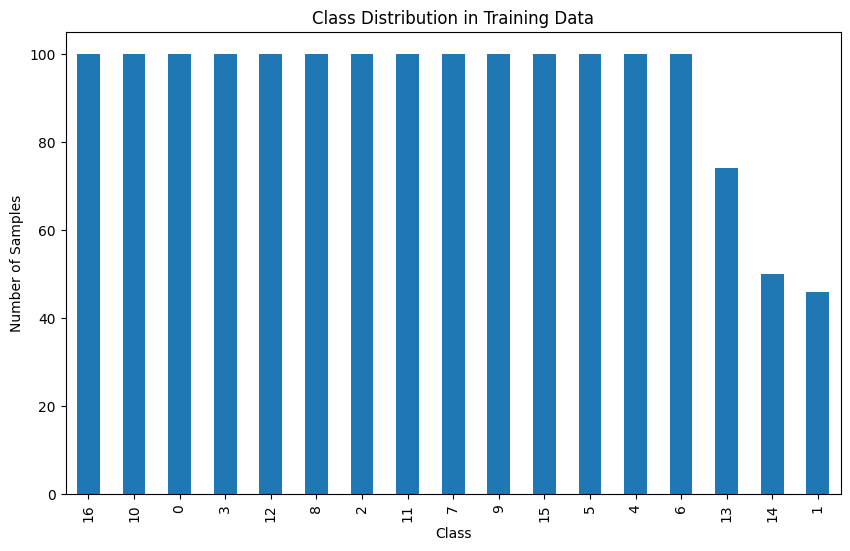

In [ ]:
# 2. 레이블 파일 읽기
labels_df = pd.read_csv(train_labels_file)

# 레이블 분포 확인
class_counts = labels_df['target'].value_counts()
print("Class distribution in training data:")
print(class_counts)

# 클래스 분포 시각화
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

Sample images from training data:


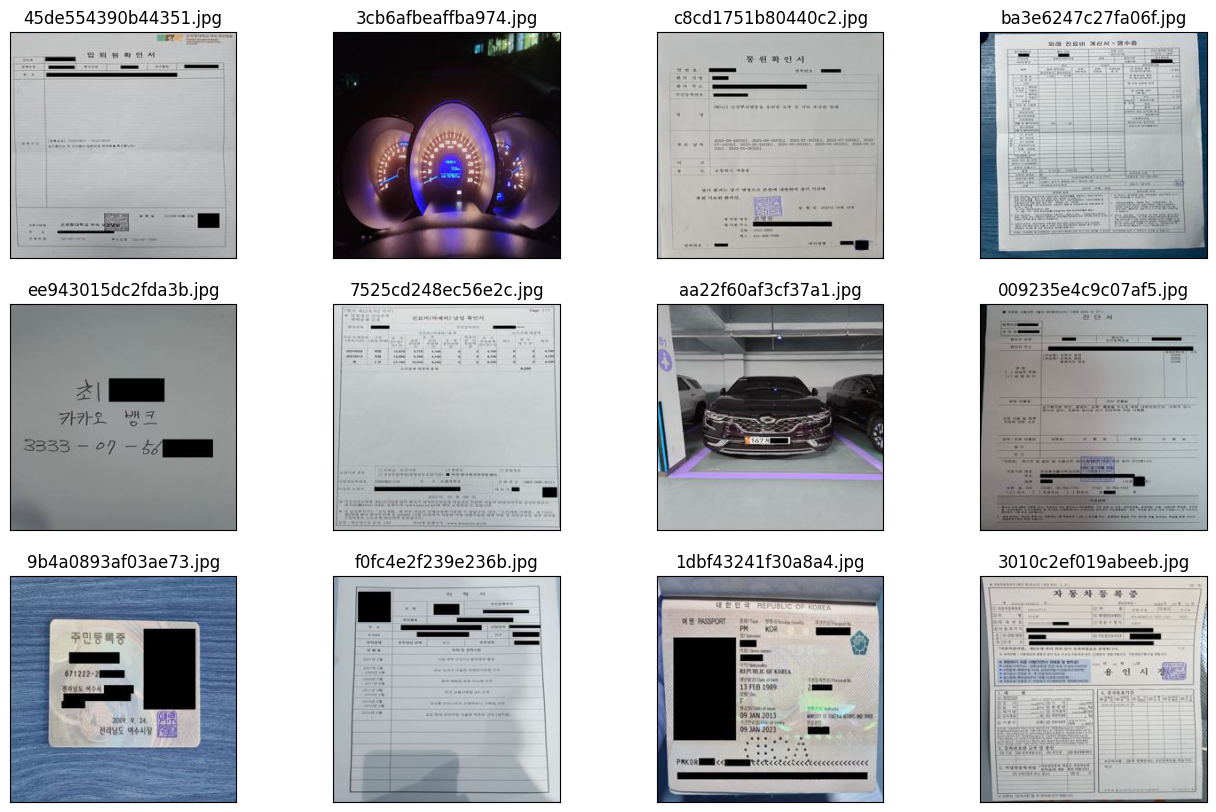

Sample images from test data:


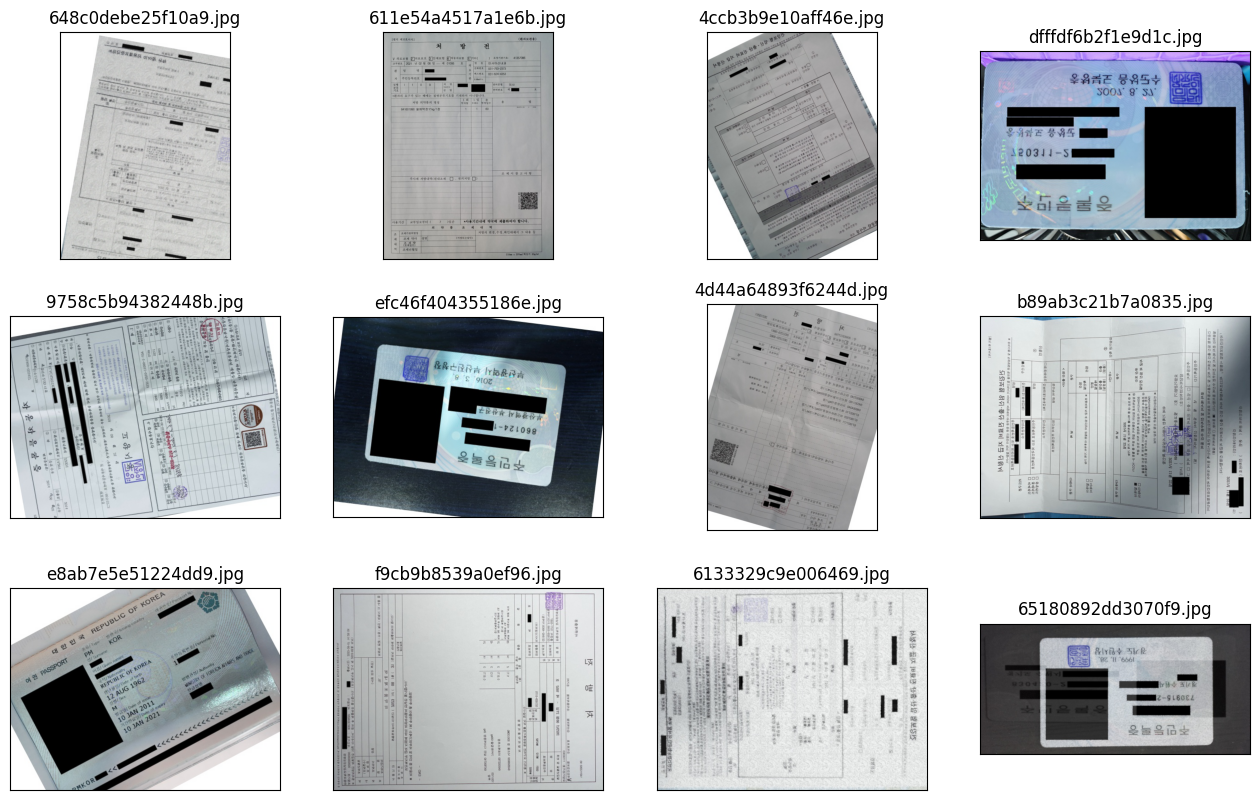

In [ ]:
# 3. 이미지 샘플 시각화

def display_sample_images(image_files, data_dir, num_samples=12):
    plt.figure(figsize=(16, 10))
    sample_files = np.random.choice(image_files, num_samples, replace=False)

    for i, file_name in enumerate(sample_files):
        plt.subplot(3, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = Image.open(os.path.join(data_dir, file_name))
        plt.imshow(img)
        plt.title(file_name)
    
    plt.show()

print("Sample images from training data:")
display_sample_images(train_image_files, train_data_dir)

print("Sample images from test data:")
display_sample_images(test_image_files, test_data_dir)

Image size statistics for training data:
Average width: 256.0
Average height: 256.0
Width standard deviation: 0.0
Height standard deviation: 0.0


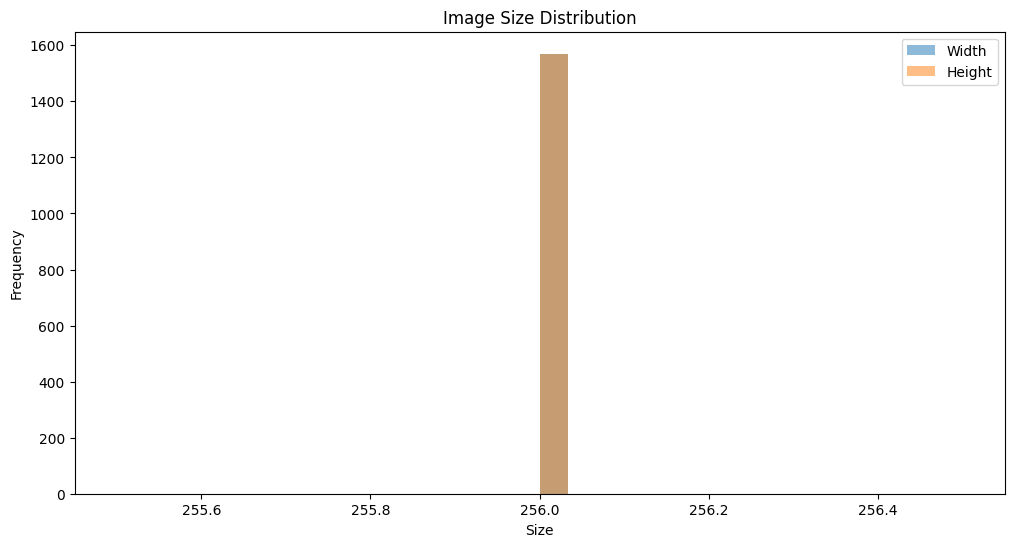

Image size statistics for test data:
Average width: 517.0850318471338
Average height: 518.5563694267516
Width standard deviation: 79.83384077346084
Height standard deviation: 79.79125836618759


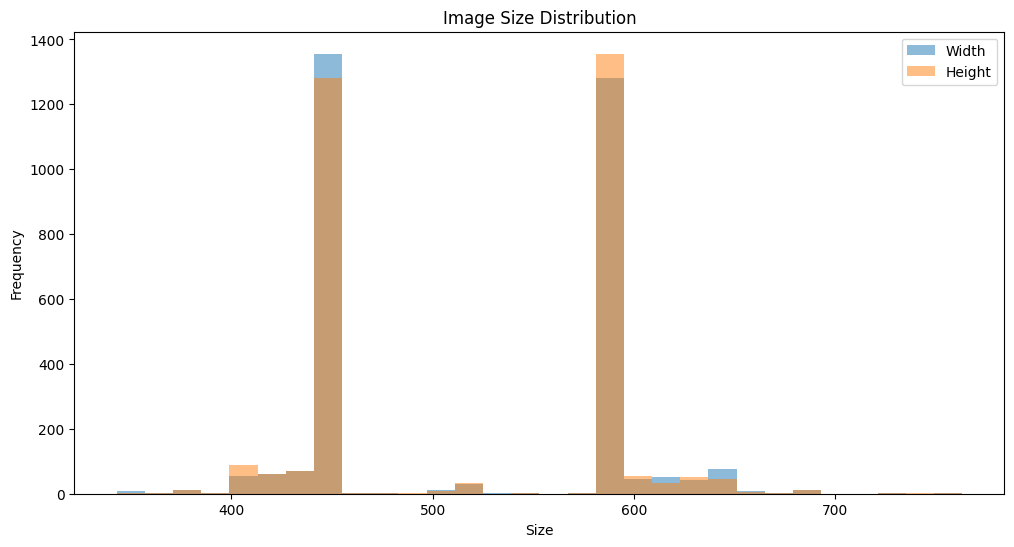

In [ ]:
# 4. 이미지 크기 통계 확인

def image_size_stats(image_files, data_dir):
    widths = []
    heights = []
    
    for file_name in image_files:
        with Image.open(os.path.join(data_dir, file_name)) as img:
            widths.append(img.width)
            heights.append(img.height)
    
    print(f"Average width: {np.mean(widths)}")
    print(f"Average height: {np.mean(heights)}")
    print(f"Width standard deviation: {np.std(widths)}")
    print(f"Height standard deviation: {np.std(heights)}")
    
    # 이미지 크기 분포 시각화
    plt.figure(figsize=(12, 6))
    plt.hist(widths, bins=30, alpha=0.5, label='Width')
    plt.hist(heights, bins=30, alpha=0.5, label='Height')
    plt.title('Image Size Distribution')
    plt.xlabel('Size')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

print("Image size statistics for training data:")
image_size_stats(train_image_files, train_data_dir)

print("Image size statistics for test data:")
image_size_stats(test_image_files, test_data_dir)

In [ ]:
# 5. 클래스 불균형

from sklearn.utils.class_weight import compute_class_weight

# 레이블 파일에서 클래스 레이블 목록 생성
class_labels = labels_df['target'].unique()

# 클래스 가중치 계산
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=labels_df['target']
)
class_weights_dict = dict(zip(class_labels, class_weights))

print("Class weights:", class_weights_dict)

# 6. corrupted 이미지 품질 검토

def check_image_quality(image_files, data_dir):
    corrupted_files = []
    for file_name in image_files:
        try:
            with Image.open(os.path.join(data_dir, file_name)) as img:
                img.verify()  # 이미지 파일이 손상되지 않았는지 검증
        except (IOError, SyntaxError) as e:
            corrupted_files.append(file_name)
    
    if corrupted_files:
        print(f"Found {len(corrupted_files)} corrupted or unreadable images.")
        # 옵션: 손상된 이미지 파일 목록 출력
        # print("Corrupted files:", corrupted_files)
    else:
        print("No corrupted files found.")

print("Checking image quality for training data:")
check_image_quality(train_image_files, train_data_dir)

Class weights: {16: 0.9235294117647059, 10: 0.9235294117647059, 4: 0.9235294117647059, 5: 0.9235294117647059, 15: 0.9235294117647059, 14: 1.8470588235294119, 9: 0.9235294117647059, 13: 1.248012718600954, 7: 0.9235294117647059, 11: 0.9235294117647059, 2: 0.9235294117647059, 8: 0.9235294117647059, 12: 0.9235294117647059, 3: 0.9235294117647059, 0: 0.9235294117647059, 1: 2.0076726342710995, 6: 0.9235294117647059}
Checking image quality for training data:
No corrupted files found.


In [ ]:
## 이미지 크기 통일 256x256 or 512x512
def resize_image(image_path, size=(256, 256)):
    with Image.open(image_path) as img:
        img = img.resize(size)
        return img

# 모든 이미지를 256x256 크기로 리사이즈
for file_name in train_image_files:
    img = resize_image(os.path.join(train_data_dir, file_name))
    img.save(os.path.join(train_data_dir, file_name))

In [ ]:
# 클래스별 가중치 정의
#  클래스 1, 13, 14에 대해 높은 가중치를 주고, 나머지 클래스는 기본 가중치를 적용
class_weights = {
    0: 1.0,  # 기본 가중치
    1: 2.0,  # 1에 높은 가중치
    2: 1.0,
    3: 1.0,
    4: 1.0,
    5: 1.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
    10: 1.0,
    11: 1.0,
    12: 1.0,
    13: 1.5,  # 13에 높은 가중치
    14: 1.5,  # 14에 높은 가중치
    15: 1.0
}

# 클래스 가중치 텐서로 변환
num_classes = len(class_weights)
weights = torch.tensor([class_weights[i] for i in range(num_classes)], dtype=torch.float32)

# CrossEntropyLoss에 클래스 가중치 적용
criterion = nn.CrossEntropyLoss(weight=weights)

# 예제: 모델 훈련 루프에서 criterion 사용
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for images, targets in dataloader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    return average_loss

Agmentation

In [ ]:
import augraphy

print(augraphy.__version__)

8.2.6


In [ ]:
# # augmentation을 위한 transform 코드
# trn_transform = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])
# trn_transform_coarseDropout = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.CoarseDropout(max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate45 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(45, 45), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate90 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
#     A.Rotate(limit=(90, 90), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate135 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(135, 135), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate180 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(180, 180), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate225 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(225, 225), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_rotate270 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(270, 270), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_rotate315 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(315, 315), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_verticalflip = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.VerticalFlip(always_apply=False, p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_horizontalflip = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.HorizontalFlip(always_apply=False, p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_blur = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Blur(always_apply=True, p=1.0, blur_limit=(3, 3)),
#     ToTensorV2(),
# ])
# trn_transform_gaussnoise = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.GaussNoise(always_apply=False, p=1.0, var_limit=(500.0, 500.0)),
#     ToTensorV2(),
# ])
# trn_transform_downscale = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Downscale(always_apply=False, p=1.0, scale_min=0.5, scale_max=0.5, interpolation=0),
#     ToTensorV2(),
# ])
# transform_list = [trn_transform, trn_transform_coarseDropout, trn_transform_rotate45, trn_transform_rotate90, trn_transform_rotate135, trn_transform_rotate180, trn_transform_rotate225,
#                   trn_transform_rotate270, trn_transform_rotate315, trn_transform_verticalflip, trn_transform_horizontalflip, trn_transform_blur, trn_transform_gaussnoise,
#                   trn_transform_downscale]

# # test image 변환을 위한 transform 코드
# tst_transform = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])

### 3. Define function

In [ ]:
# 데이터셋 클래스를 정의
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    # 데이터셋의 전체 길이 반환
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [ ]:
# one epoch 학습을 위한 함수
# 데이터 로더(loader), 모델(model), 옵티마이저(optimizer), 손실 함수(loss_fn), 연산에 사용할 장치(device)
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    # 모델 학습 모드
    model.train()
    # 학습 과정에서 누적된 손실(train_loss)을 저장, 예측값(preds_list)과 실제 정답(targets_list)을 저장할 리스트를 초기화
    train_loss = 0
    preds_list = []
    targets_list = []

    # 데이터 로더를 진행 바(progress bar)로 시각화 
    pbar = tqdm(loader)
    
    # 데이터 로더에서 배치(batch) 단위로 이미지를 가져와 반복문
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)
        # 이전 배치의 그래디언트를 초기화, set_to_none=True는 메모리 사용을 최적화하기 위해 그래디언트를 0으로 설정하지 않고 None으로 설정
        model.zero_grad(set_to_none=True)

        # 예측값(preds)
        preds = model(image)
        # 모델의 예측값(preds)과 실제 정답(targets)을 비교하여 손실(loss)을 계산합니다. 손실 함수(loss_fn)은 주로 교차 엔트로피(Cross-Entropy) 손실이나 MSE 등이 사용
        loss = loss_fn(preds, targets)
        # 역전파를 통해 손실의 그래디언트를 계산하고, 이 그래디언트가 각 모델 파라미터에 적용
        loss.backward()
        # 옵티마이저를 사용하여 모델 파라미터를 업데이트, 손실 최소화 방향 가중치 조절 
        optimizer.step()

        # 현재 배치의 손실 값을 누적하여 총 손실(train_loss)에 더함. loss.item()은 텐서 형태의 손실 값을 파이썬의 숫자로 변환
        train_loss += loss.item()
        # 모델의 예측값에서 가장 높은 확률을 가진 클래스를 선택하여 preds_list에 추가, 
        # argmax(dim=1): 각 예측에서 가장 높은 확률을 가진 클래스를 선택 / detach().cpu().numpy(): 텐서를 넘파이 배열로 변환하여 CPU로 이동시킴
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        # 실제 정답(targets)도 targets_list에 추가
        targets_list.extend(targets.detach().cpu().numpy())
        # 시각화 바 
        pbar.set_description(f"Loss: {loss.item():.4f}")

    # 총 손실을 배치의 개수로 나누어 평균 손실(train_loss)을 계산
    train_loss /= len(loader)
    # 누적된 예측값과 실제 정답을 사용해 학습 정확도(train_acc)와 F1 점수(train_f1)를 계산
    train_acc = accuracy_score(targets_list, preds_list)
    # f1_score에서 average='macro'는 각 클래스의 F1 점수를 개별적으로 계산한 후 그 평균을 취하는 방법을 의미
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    # 학습 손실(train_loss), 학습 정확도(train_acc), 학습 F1 점수(train_f1)를 딕셔너리로 묶어 반환할 결과를 만듦 
    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }
    # 결과 반환, 로그 기록 
    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [ ]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'datasets_fin/'

# model config
model_name = 'resnet34' # 'resnet50' 'efficientnet-b0', ...

# training config
img_size = 128
LR = 1e-3
EPOCHS = 30
BATCH_SIZE = 32
num_workers = 0

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [ ]:
# augmentation을 위한 transform 코드
trn_transform = A.Compose([
    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),
    # images normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [ ]:
# Dataset 정의
trn_dataset = ImageDataset(
    "/data/ephemeral/home/data/train.csv",
    "/data/ephemeral/home/data//train/",
    transform=trn_transform
)
tst_dataset = ImageDataset(
    "/data/ephemeral/home/data/sample_submission.csv",
    "/data/ephemeral/home/data/test",
    transform=tst_transform
)
print(len(trn_dataset), len(tst_dataset))

1570 3140


In [ ]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [ ]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [ ]:
for epoch in range(EPOCHS):
    ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
    ret['epoch'] = epoch

    log = ""
    for k, v in ret.items():
      log += f"{k}: {v:.4f}\n"
    print(log)

Loss: 1.5501: 100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


train_loss: 1.6838
train_acc: 0.5541
train_f1: 0.4936
epoch: 0.0000



Loss: 0.7656: 100%|██████████| 50/50 [00:08<00:00,  6.24it/s]


train_loss: 0.4041
train_acc: 0.8650
train_f1: 0.8391
epoch: 1.0000



Loss: 1.7335: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


train_loss: 0.2412
train_acc: 0.9268
train_f1: 0.9148
epoch: 2.0000



Loss: 2.7473: 100%|██████████| 50/50 [00:08<00:00,  5.68it/s]


train_loss: 0.1930
train_acc: 0.9529
train_f1: 0.9506
epoch: 3.0000



Loss: 4.8582: 100%|██████████| 50/50 [00:08<00:00,  5.94it/s]


train_loss: 0.1822
train_acc: 0.9720
train_f1: 0.9706
epoch: 4.0000



Loss: 2.7896: 100%|██████████| 50/50 [00:08<00:00,  5.68it/s]


train_loss: 0.1558
train_acc: 0.9675
train_f1: 0.9657
epoch: 5.0000



Loss: 0.9024: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


train_loss: 0.1180
train_acc: 0.9707
train_f1: 0.9682
epoch: 6.0000



Loss: 0.4972: 100%|██████████| 50/50 [00:08<00:00,  5.88it/s]


train_loss: 0.0824
train_acc: 0.9745
train_f1: 0.9720
epoch: 7.0000



Loss: 0.3199: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


train_loss: 0.0522
train_acc: 0.9834
train_f1: 0.9820
epoch: 8.0000



Loss: 0.2248: 100%|██████████| 50/50 [00:08<00:00,  5.88it/s]


train_loss: 0.0486
train_acc: 0.9822
train_f1: 0.9820
epoch: 9.0000



Loss: 2.6948: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


train_loss: 0.0739
train_acc: 0.9943
train_f1: 0.9941
epoch: 10.0000



Loss: 0.0061:  82%|████████▏ | 41/50 [00:07<00:01,  5.62it/s]


KeyboardInterrupt: 

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [ ]:
preds_list = []

model.eval()
for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:10<00:00,  9.08it/s]


In [ ]:
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [ ]:
sample_submission_df = pd.read_csv("/data/ephemeral/home/data/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [ ]:
pred_df.to_csv("pred.csv", index=False)

In [ ]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,16
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,9
3,00471f8038d9c4b6.jpg,6
4,00901f504008d884.jpg,2
